### **Import libraries**

In [1]:
import os
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from sklearn.impute import SimpleImputer
from tensorflow.keras.preprocessing.sequence import pad_sequences




In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### **Path to the files**

In [3]:
session1 = "/content/drive/MyDrive/osfstorage-archive/1.0 Sessions"
demographics_file = r"/content/drive/MyDrive/osfstorage-archive/Demographic_Info.csv"

### **Preprocessing**

In [4]:
csv_files = glob.glob(os.path.join(session1, "*.csv"))
dataframes = []
for file in csv_files:
    df = pd.read_csv(file, encoding='utf-8-sig') # Read the CSV
    df.columns = df.columns.str.strip()  # Clean column names
    raw_name = os.path.splitext(os.path.basename(file))[0]
    child_id = raw_name.split('_Exported')[0]

    # Inject 'Child ID' into all rows if missing or all null
    if 'Child ID' not in df.columns or df['Child ID'].isnull().all():
        df['Child ID'] = [child_id] * len(df)  # Assign to all rows
        print(f"Injected Child ID into: {os.path.basename(file)}")

    # Add to list
    dataframes.append(df)

# Combine all cleaned data
combined_df = pd.concat(dataframes, ignore_index=True, sort=False)


Injected Child ID into: ASLPLAY_21_Exported_05_31_24.csv
Injected Child ID into: ASLPLAY_18_Exported_05_31_24.csv
Injected Child ID into: ASLPLAY_22_Exported_05_31_24.csv
Injected Child ID into: ASLPLAY_19_Exported_05_31_24.csv
Injected Child ID into: ASLPLAY_24_Exported_05_31_24.csv
Injected Child ID into: ASLPLAY_23_Exported_05_31_24.csv
Injected Child ID into: ASLPLAY_17_Exported_05_31_24.csv


In [5]:
# Load demographics CSV
demographics = pd.read_csv(demographics_file)
demographics.columns = demographics.columns.str.strip() # remove any space in header

In [6]:
# Merge session1 with demographics
merged_data = pd.merge(combined_df, demographics, on='Child ID', how='left')
merged_data.to_csv(r"C:\Users\tiasa\Downloads\merged_data.csv", index=False)

In [7]:
# Preview the result
print("Unique Child IDs:", sorted(merged_data['Child ID'].unique()))
print("Final merged dataset shape:", merged_data.shape)
print(merged_data.columns)
print(merged_data.head())

Unique Child IDs: ['ASLPLAY_01', 'ASLPLAY_02', 'ASLPLAY_03', 'ASLPLAY_04', 'ASLPLAY_05', 'ASLPLAY_06', 'ASLPLAY_07', 'ASLPLAY_08', 'ASLPLAY_09', 'ASLPLAY_10', 'ASLPLAY_11', 'ASLPLAY_12', 'ASLPLAY_13', 'ASLPLAY_14', 'ASLPLAY_15', 'ASLPLAY_16', 'ASLPLAY_17', 'ASLPLAY_18', 'ASLPLAY_19', 'ASLPLAY_20', 'ASLPLAY_21', 'ASLPLAY_22', 'ASLPLAY_23', 'ASLPLAY_24']
Final merged dataset shape: (40265, 74)
Index(['Child ID', 'Begin Time - ss.msec', 'End Time - ss.msec',
       'Duration - ss.msec', 'Adult Attention Getting Strategies',
       'Adult1 ASL Dominant hand', 'Adult1 Dominant Hand append', 'Adult1 NMS',
       'Adult1 Non-Dominant Hand append', 'Adult1 Non-Dominant hand',
       'Adult1 free translation', 'Child ASL Dominant hand',
       'Child ASL Dominant hand append', 'Child ASL Non-Dominant hand',
       'Child Attention Getting Strategies', 'Child NMS',
       'Child Non-Dominant Hand append', 'Child Spoken English Transcription',
       'Child Spoken English append', 'Child free tra

### **Feature Engineering**

In [8]:
asl_columns = [
    'Child ASL Dominant hand',
    'Child ASL Non-Dominant hand',
    'Child ASL Dominant hand pho',
    'Child ASL Non-Dominant pho',
    'Child NMS',
    'Child ASL feedback',
    'Child free translation'
]

# Count non-null values across these columns per row
merged_data['ASL_Activity'] = merged_data[asl_columns].notna().sum(axis=1)

# Sum by Child ID
asl_scores = merged_data.groupby('Child ID')['ASL_Activity'].sum().reset_index()
asl_scores = asl_scores.rename(columns={'ASL_Activity': 'ASL_Score'})

merged_data = pd.merge(merged_data, asl_scores, on='Child ID', how='left')

print(asl_scores.sort_values(by='ASL_Score', ascending=False))


      Child ID  ASL_Score
20  ASLPLAY_21        365
22  ASLPLAY_23        251
21  ASLPLAY_22        210
15  ASLPLAY_16        189
23  ASLPLAY_24        168
5   ASLPLAY_06        137
18  ASLPLAY_19        113
14  ASLPLAY_15         97
19  ASLPLAY_20         78
17  ASLPLAY_18         60
12  ASLPLAY_13         59
2   ASLPLAY_03         58
16  ASLPLAY_17         54
11  ASLPLAY_12         47
7   ASLPLAY_08         44
6   ASLPLAY_07         37
13  ASLPLAY_14         36
9   ASLPLAY_10         23
1   ASLPLAY_02         20
10  ASLPLAY_11         17
3   ASLPLAY_04         12
8   ASLPLAY_09         12
4   ASLPLAY_05          0
0   ASLPLAY_01          0


### **EDA**

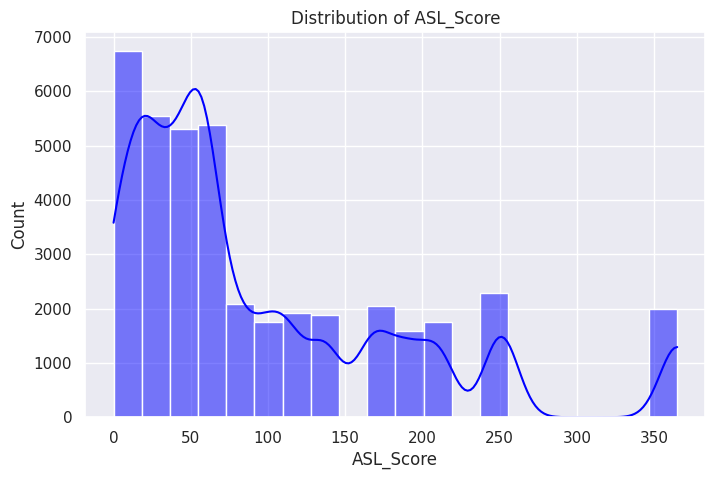

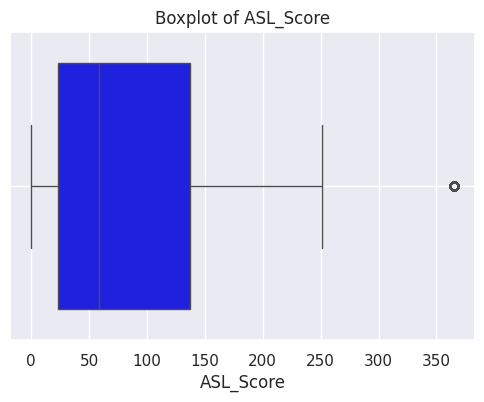

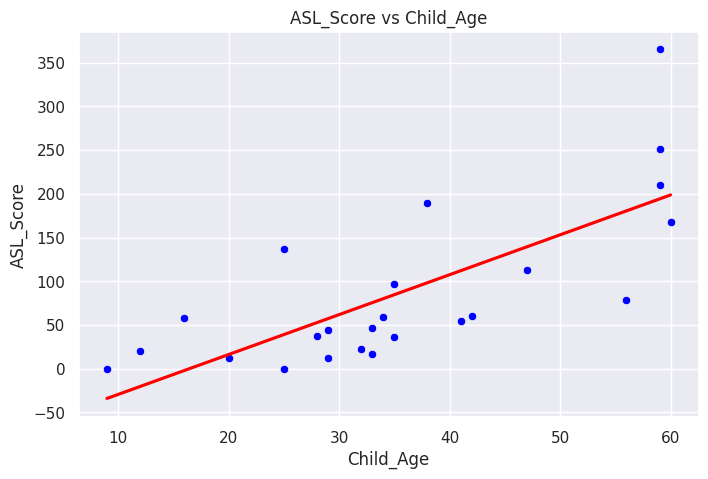

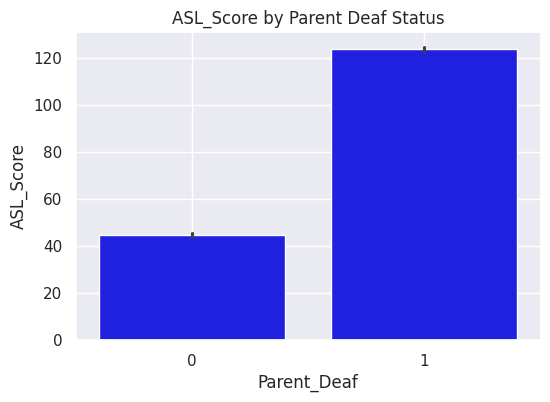

In [9]:
# Set up seaborn style
sns.set(style='dark', palette='pastel')

# Distribution of ASL_Score
plt.figure(figsize=(8, 5))
sns.histplot(merged_data['ASL_Score'], kde=True, bins=20, color= "blue")
plt.title("Distribution of ASL_Score")
plt.xlabel("ASL_Score")
plt.ylabel("Count")
plt.grid("dashed")
plt.savefig("Distribution_asl_score.jpg", dpi=300)

# Boxplot to check for outliers
plt.figure(figsize=(6, 4))
sns.boxplot(x=merged_data['ASL_Score'], color="blue")
plt.title("Boxplot of ASL_Score")
plt.xlabel("ASL_Score")
plt.grid("dashed")
plt.savefig("Boxplot.jpg", dpi=300)

# ASL_Score vs Child Age
plt.figure(figsize=(8, 5))
sns.scatterplot(data=merged_data, x='Child_Age', y='ASL_Score', color="blue")
sns.regplot(data=merged_data, x='Child_Age', y='ASL_Score', scatter=False, color='red')
plt.title("ASL_Score vs Child_Age")
plt.xlabel("Child_Age")
plt.ylabel("ASL_Score")
plt.grid("dashed")
plt.savefig("ASL_Score_vs_Child_Age.jpg", dpi=300)


# ASL_Score by Parent Deaf status
plt.figure(figsize=(6, 4))
sns.barplot(data=merged_data, x='Parent_Deaf', y='ASL_Score', color="blue")
plt.xlabel("Parent_Deaf")
plt.ylabel("ASL_Score")
plt.title("ASL_Score by Parent Deaf Status")
plt.grid("dashed")
plt.savefig("ASL_Score_by_Parent_Deaf.jpg", dpi=300)



In [10]:
interaction_cols = [
    'EYE GAZE (adult)',
    'EYE GAZE (child)',
    'Object touch (adult) Left',
    'Object touch (adult) Right',
    'Object touch (child) Left',
    'Object touch (child) Right'
]

# count number of non-null entries per child per column
interaction_counts = merged_data.groupby('Child ID')[interaction_cols].apply(
    lambda df: df.notnull().sum()
).reset_index()

# Merge with other features
final_features = interaction_counts.merge(
    merged_data[['Child ID', 'Child_Age', 'Parent_Deaf', 'Voice_Coded', 'ASL_Score']].drop_duplicates(),
    on='Child ID',
    how='left'
)
final_features

,Child ID,EYE GAZE (adult),EYE GAZE (child),Object touch (adult) Left,Object touch (adult) Right,Object touch (child) Left,Object touch (child) Right,Child_Age,Parent_Deaf,Voice_Coded,ASL_Score
0,ASLPLAY_01,407,319,109,138,69,67,9,0,1,0
1,ASLPLAY_02,425,298,82,92,68,75,12,0,1,20
2,ASLPLAY_03,369,281,127,114,45,42,16,0,1,58
3,ASLPLAY_04,133,116,10,13,20,20,20,0,1,12
4,ASLPLAY_05,340,372,141,96,149,159,25,1,1,0
5,ASLPLAY_06,459,395,43,149,78,82,25,1,0,137
6,ASLPLAY_07,409,230,89,107,113,65,28,1,0,37
7,ASLPLAY_08,402,288,45,104,71,73,29,1,0,44
8,ASLPLAY_09,310,232,63,51,65,60,29,0,1,12
9,ASLPLAY_10,687,478,67,88,127,145,32,0,1,23


In [11]:
# Define features and target
X = final_features.drop(columns=['Child ID', 'ASL_Score'])
y = final_features['ASL_Score']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)
# Scaling the variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Linear Regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Linear Regression MSE: {mse:.2f}, R²: {r2:.2f}")

# Train Random Forest model
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluation
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest MSE: {mse_rf:.2f}, R²: {r2_rf:.2f}")

Linear Regression MSE: 9157.54, R²: -1.25
Random Forest MSE: 2223.28, R²: 0.45


### **Feature Importance**

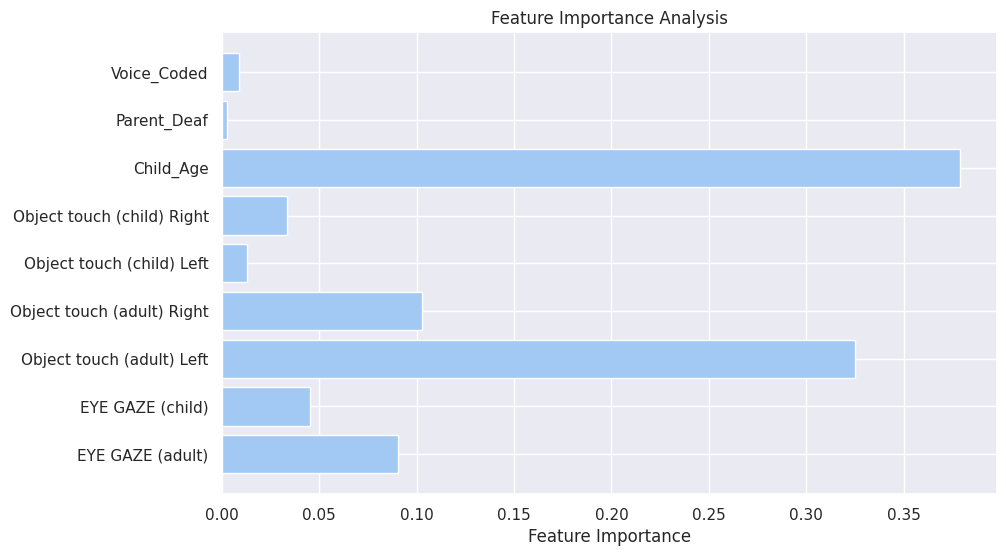

In [12]:
importances = rf.feature_importances_
features = X.columns

# Plot
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("Feature Importance Analysis")
plt.grid("dashed")
plt.savefig("Feature-imp.jpg", dpi=300)


### **Apply LSTM**

In [13]:

# Load dataset
data_path = '/content/drive/MyDrive/merged_data.csv'
merged_data = pd.read_csv(data_path)

# Select features
feature_cols = [
    'EYE GAZE (adult)', 'EYE GAZE (child)',
    'Object touch (adult) Left', 'Object touch (adult) Right',
    'Object touch (child) Left', 'Object touch (child) Right',
    'Child_Age', 'Parent_Deaf', 'Voice_Coded'
]

data = merged_data[['Child ID'] + feature_cols + ['ASL_Activity']].copy()

# Clean and impute
for col in feature_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')
imputer = SimpleImputer(strategy='constant', fill_value=0)
data[feature_cols] = imputer.fit_transform(data[feature_cols])

# Scale
scaler = StandardScaler()
data[feature_cols] = scaler.fit_transform(data[feature_cols])

# Group into sequences
sequence_data = []
sequence_targets = []

for _, group in data.groupby('Child ID'):
    X_seq = group[feature_cols].values
    y_seq = group['ASL_Activity'].values
    if len(X_seq) >= 10:
        sequence_data.append(X_seq)
        # Predict average ASL activity per child sequence
        sequence_targets.append(np.mean(y_seq))

# Pad X sequences (y is already 1D now)
X_padded = pad_sequences(sequence_data, padding='post', dtype='float32')
y_array = np.array(sequence_targets, dtype='float32')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_array, test_size=0.2, random_state=42)

# LSTM model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# LR scheduler
def scheduler(epoch, lr):
    return lr if epoch < 10 else float(lr * tf.math.exp(-0.1))

lr_callback = LearningRateScheduler(scheduler)

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=4,
    callbacks=[lr_callback],
    verbose=1
)


/tmp/ipython-input-13-3730432885.py:3: DtypeWarning: Columns (7,14,17,26,36,37,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,60,61,62,63,64,65,67,68,69,70) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_data = pd.read_csv(data_path)
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 0.0087 - mae: 0.0617 - val_loss: 6.4723e-04 - val_mae: 0.0214 - learning_rate: 0.0010
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 950ms/step - loss: 0.0075 - mae: 0.0527 - val_loss: 0.0012 - val_mae: 0.0268 - learning_rate: 0.0010
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 0.0029 - mae: 0.0432 - val_loss: 0.0012 - val_mae: 0.0272 - learning_rate: 0.0010
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 934ms/step - loss: 0.0030 - mae: 0.0464 - val_loss: 8.6924e-04 - val_mae: 0.0229 - learning_rate: 0.0010
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 990ms/step - loss: 0.0020 - mae: 0.0358 - val_loss: 5.9195e-04 - val_mae: 0.0208 - learning_rate: 0.0010
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.0022 - mae: 0.0365 - val_loss: 6.9067e-04 - val_mae: 0.0217 - learning_rate: 0.0010
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 878ms/step - loss: 0.0046 - mae: 0.0522 - val_loss: 9.7579e-04 - val_mae: 0.0239 - learning_rate: 0.0010
Epoch 8/

In [14]:
# Predict on both train and test
y_train_pred = model.predict(X_train).flatten()
y_test_pred = model.predict(X_test).flatten()

# Training Metrics
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

# Test Metrics
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

# Print results
print("Training Metrics:")
print(f"  MAE:  {mae_train:.4f}")
print(f"  MSE:  {mse_train:.4f}")
print(f"  RMSE: {rmse_train:.4f}")
print(f"  R²:   {r2_train:.4f}\n")

print("Test Metrics:")
print(f"  MAE:  {mae_test:.4f}")
print(f"  MSE:  {mse_test:.4f}")
print(f"  RMSE: {rmse_test:.4f}")
print(f"  R²:   {r2_test:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
Training Metrics:
  MAE:  0.0370
  MSE:  0.0023
  RMSE: 0.0476
  R²:   0.0036

Test Metrics:
  MAE:  0.0224
  MSE:  0.0008
  RMSE: 0.0281
  R²:   -0.5181


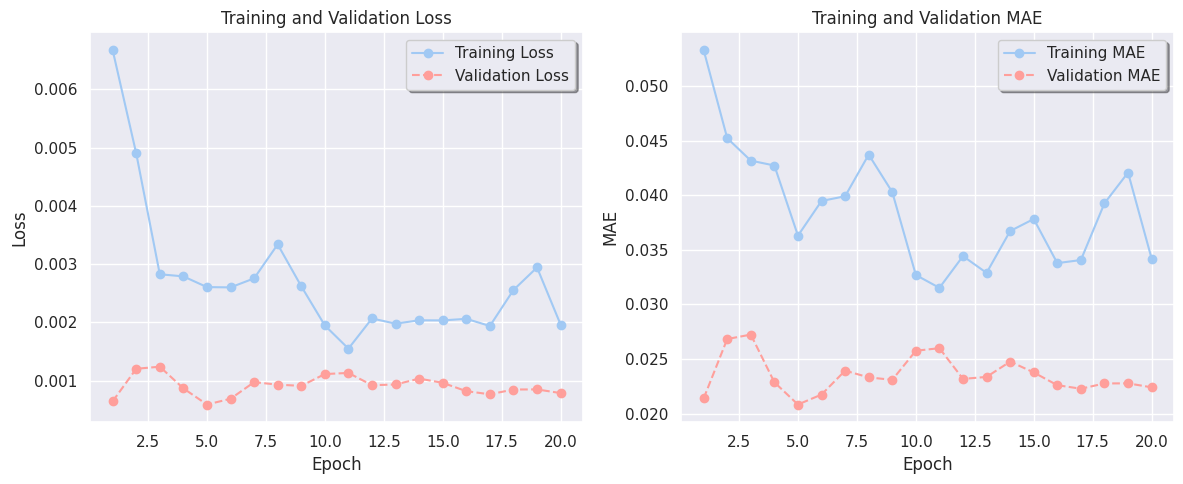

In [15]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Extract metrics
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    mae = history.history['mae']
    val_mae = history.history['val_mae']
    lr = history.history['learning_rate']
    epochs = range(1, len(loss) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro--', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid("dashed")
    plt.legend(shadow=True)

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(epochs, mae, 'bo-', label='Training MAE')
    plt.plot(epochs, val_mae, 'ro--', label='Validation MAE')
    plt.title('Training and Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.grid("dashed")
    plt.legend(shadow=True)

    plt.tight_layout()
    plt.savefig("Loss-Metric.jpg", dpi=300)

# Usage
plot_training_history(history)


In [16]:
# Load dataset
data_path = '/content/drive/MyDrive/merged_data.csv'
merged_data = pd.read_csv(data_path)

# Select features
feature_cols = [
    'EYE GAZE (adult)', 'EYE GAZE (child)',
    'Object touch (adult) Left', 'Object touch (adult) Right',
    'Object touch (child) Left', 'Object touch (child) Right',
    'Child_Age', 'Parent_Deaf', 'Voice_Coded'
]

data = merged_data[['Child ID'] + feature_cols + ['ASL_Activity']].copy()

# Clean and impute
for col in feature_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')

imputer = SimpleImputer(strategy='constant', fill_value=0)
data[feature_cols] = imputer.fit_transform(data[feature_cols])

# Scale
scaler = StandardScaler()
data[feature_cols] = scaler.fit_transform(data[feature_cols])

# Group into sequences
sequence_data = []
sequence_targets = []

for _, group in data.groupby('Child ID'):
    X_seq = group[feature_cols].values
    y_seq = group['ASL_Activity'].values
    if len(X_seq) >= 10:
        sequence_data.append(X_seq)
        sequence_targets.append(np.mean(y_seq))

# Pad sequences
X_padded = pad_sequences(sequence_data, padding='post', dtype='float32')
y_array = np.array(sequence_targets, dtype='float32')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y_array, test_size=0.2, random_state=42
)

# Define model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(32, return_sequences=False),       # Reduced from 64
    Dense(32, activation='relu'),
    Dropout(0.2),                           # Reduced from 0.3
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Learning rate scheduler
def scheduler(epoch, lr):
    return lr if epoch < 10 else float(lr * tf.math.exp(-0.1))

lr_callback = LearningRateScheduler(scheduler)

# Early stopping to avoid overfitting
early_stop = EarlyStopping(
    monitor='val_loss', patience=4, restore_best_weights=True, verbose=1
)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=4,
    callbacks=[lr_callback, early_stop],
    verbose=1
)

/tmp/ipython-input-16-1102509653.py:3: DtypeWarning: Columns (7,14,17,26,36,37,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,60,61,62,63,64,65,67,68,69,70) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_data = pd.read_csv(data_path)
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 0.0112 - mae: 0.0689 - val_loss: 5.6063e-04 - val_mae: 0.0221 - learning_rate: 0.0010
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 776ms/step - loss: 0.0029 - mae: 0.0342 - val_loss: 8.7475e-04 - val_mae: 0.0229 - learning_rate: 0.0010
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.0034 - mae: 0.0481 - val_loss: 0.0014 - val_mae: 0.0299 - learning_rate: 0.0010
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 773ms/step - loss: 0.0019 - mae: 0.0372 - val_loss: 0.0015 - val_mae: 0.0312 - learning_rate: 0.0010
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0038 - mae: 0.0520 - val_loss: 0.0014 - val_mae: 0.0301 - learning_rate: 0.0010
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.


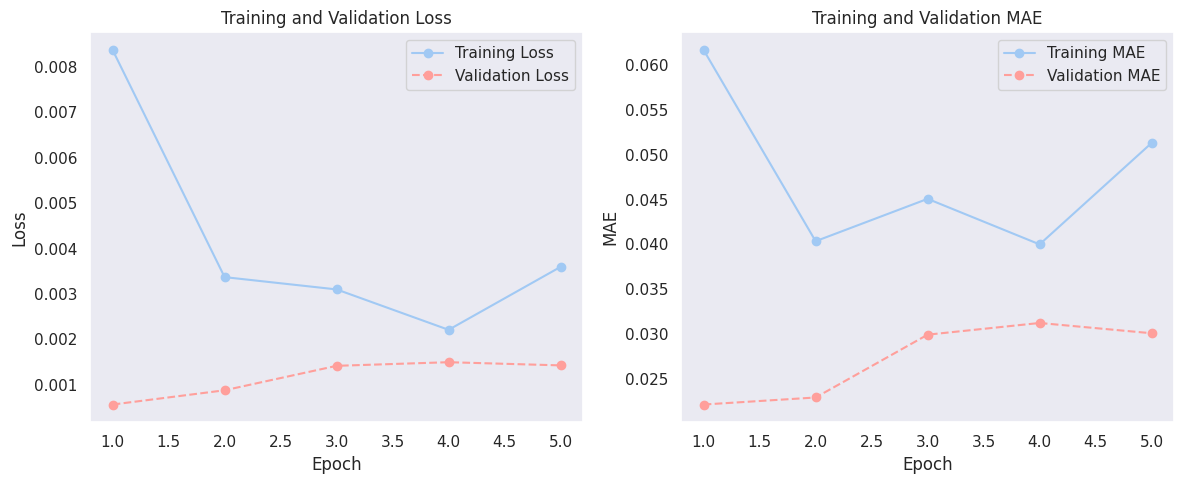

In [17]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Extract metrics
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    mae = history.history['mae']
    val_mae = history.history['val_mae']
    lr = history.history['learning_rate']
    epochs = range(1, len(loss) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro--', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(epochs, mae, 'bo-', label='Training MAE')
    plt.plot(epochs, val_mae, 'ro--', label='Validation MAE')
    plt.title('Training and Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.savefig("Loss-Metric-opt.jpg", dpi=300)

# Usage
plot_training_history(history)